# What is Trend? #

The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/ZdS4ZoJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Trend patterns in four time series.</center></figcaption>
</figure>

In this course, we'll focus on trends in the mean. More generally though, any persistent and slow-moving change in a series could constitute a trend -- time series commonly have trends in their variation for instance.

# Moving Average Plots #

To see what kind of trend a time series might have, we can use a **moving average plot**. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/EZOXiPs.gif" width=800, alt="An animated plot showing an undulating curve slowly increasing with a moving average line developing from left to right within a window of 12 points (in red).">
<figcaption style="textalign: center; font-style: italic"><center>A moving average plot illustrating a linear trend. Each point on the curve (blue) is the average of the points (red) within a window of size 12.
</center></figcaption>
</figure>

Notice how the *Mauna Loa* series above has a repeating up and down movement year after year -- a short-term, *seasonal* change. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series. For the *Mauna Loa* series, we chose a window of size 12 to smooth over the season within each year.

In [3]:
!pip uninstall statsmodels -y
!pip install --upgrade statsmodels

Found existing installation: statsmodels 0.13.2
Uninstalling statsmodels-0.13.2:
  Successfully uninstalled statsmodels-0.13.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


# Engineering Trend #

Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend:

```
target = a * time + b
```

We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us:
```
target = a * time ** 2 + b * time + c
```
Linear regression will learn the coefficients `a`, `b,` and `c`.

The trend curves in the figure below were both fit using these kinds of features and scikit-learn's `LinearRegression`:

<figure style="padding: 1em;">
<img src="https://i.imgur.com/KFYlgGm.png" width=*00, alt="Above, Cars Sold in Quebec: an undulating plot gradually increasing from 1960-01 to 1968-12 with a linear trend-line superimposed. Below, Plastics Production in Australia: an undulating plot with a concave-up quadratic trend-line superimposed.">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top:</strong> Series with a linear trend. <strong>Below:</strong> Series with a quadratic trend.
</center></figcaption>
</figure>

If you haven't seen the trick before, you may not have realized that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

# Example - Tunnel Traffic #

In this example we'll create a trend model for the *Tunnel Traffic* dataset.

In [4]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window. As we can see, the trend of *Tunnel Traffic* appears to be about linear.

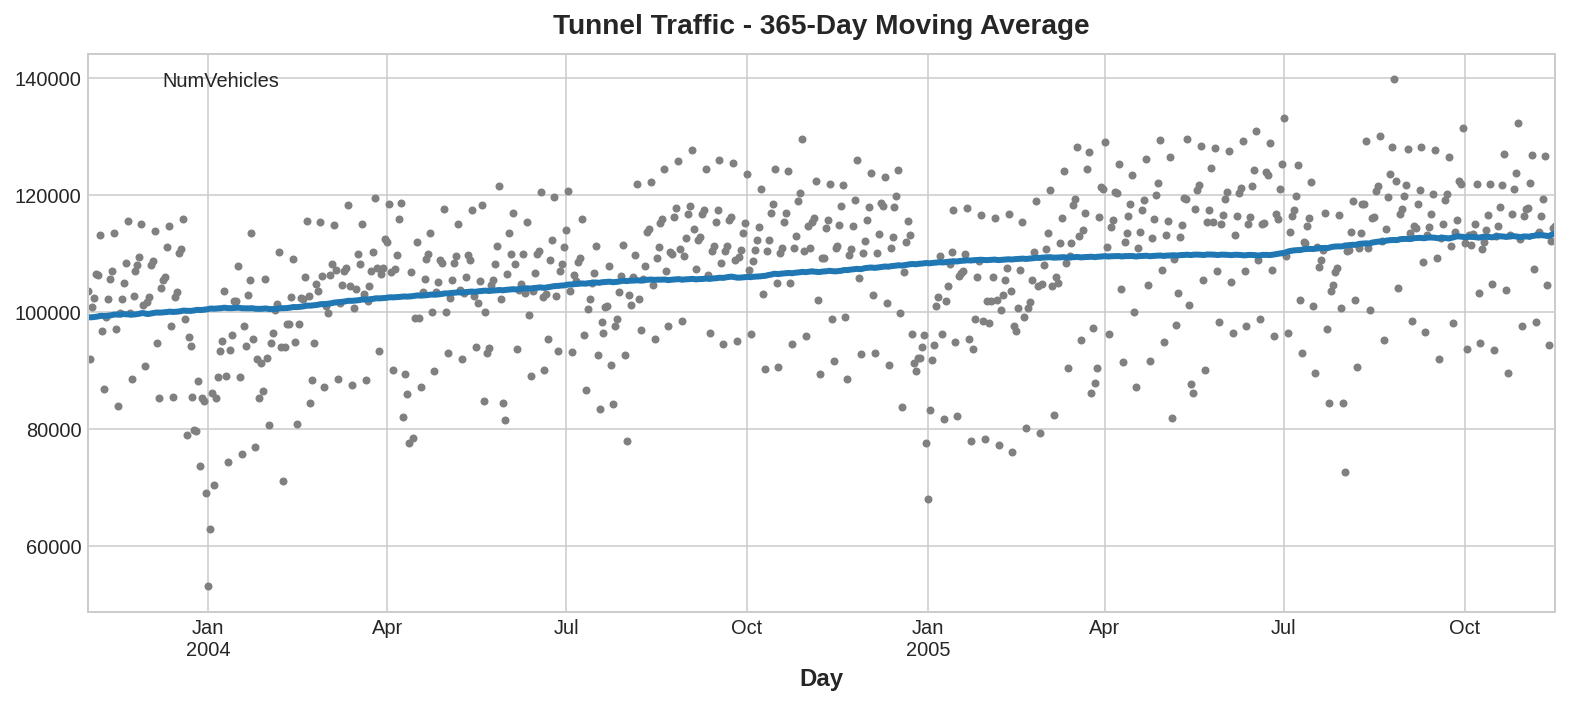

In [5]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In Lesson 1, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the `statsmodels` library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The `order` argument refers to polynomial order: `1` for linear, `2` for quadratic, `3` for cubic, and so on.

In [6]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


(A *deterministic process*, by the way, is a technical term for a time series that is non-random or completely *determined*, like the `const` and `trend` series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [7]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our `LinearRegression` model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

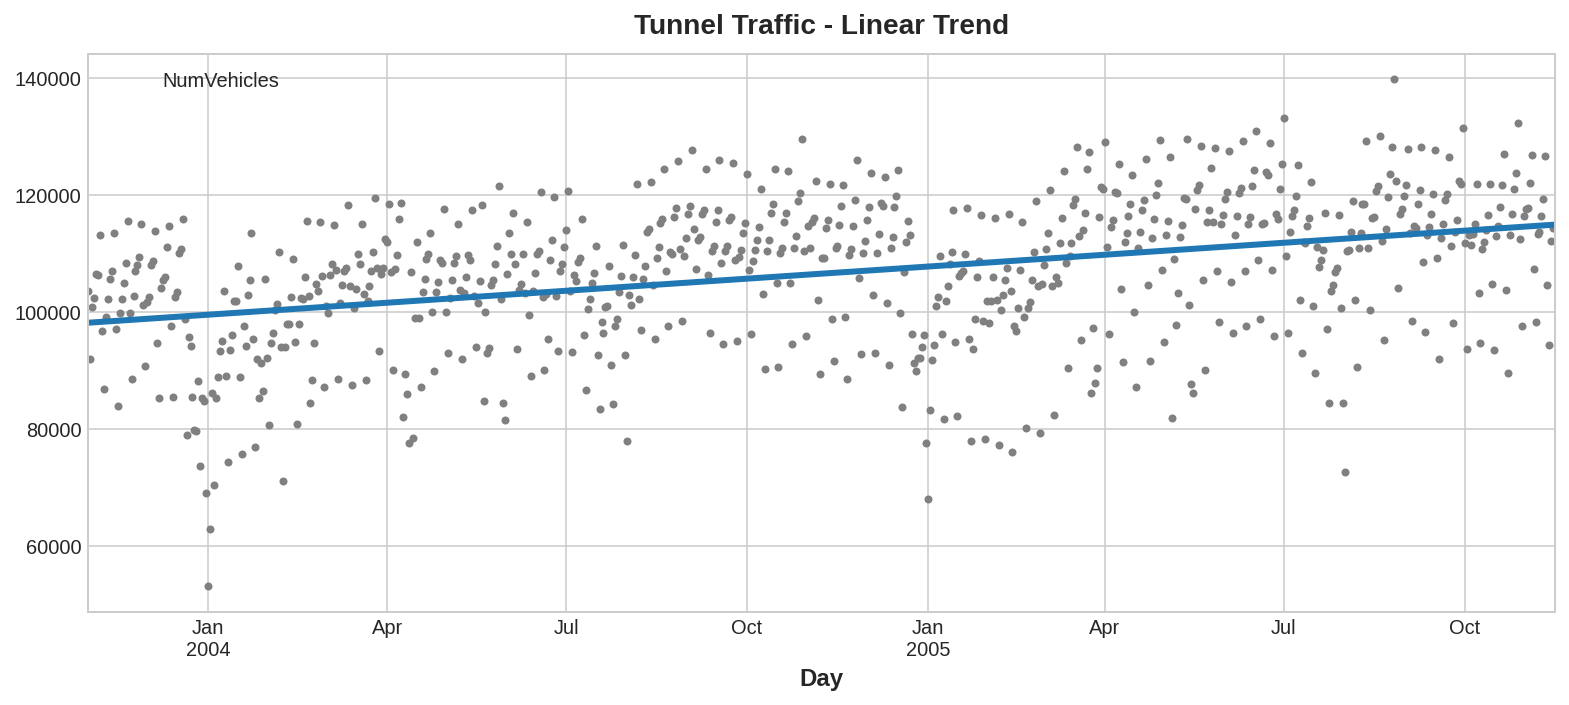

In [8]:

ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [9]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

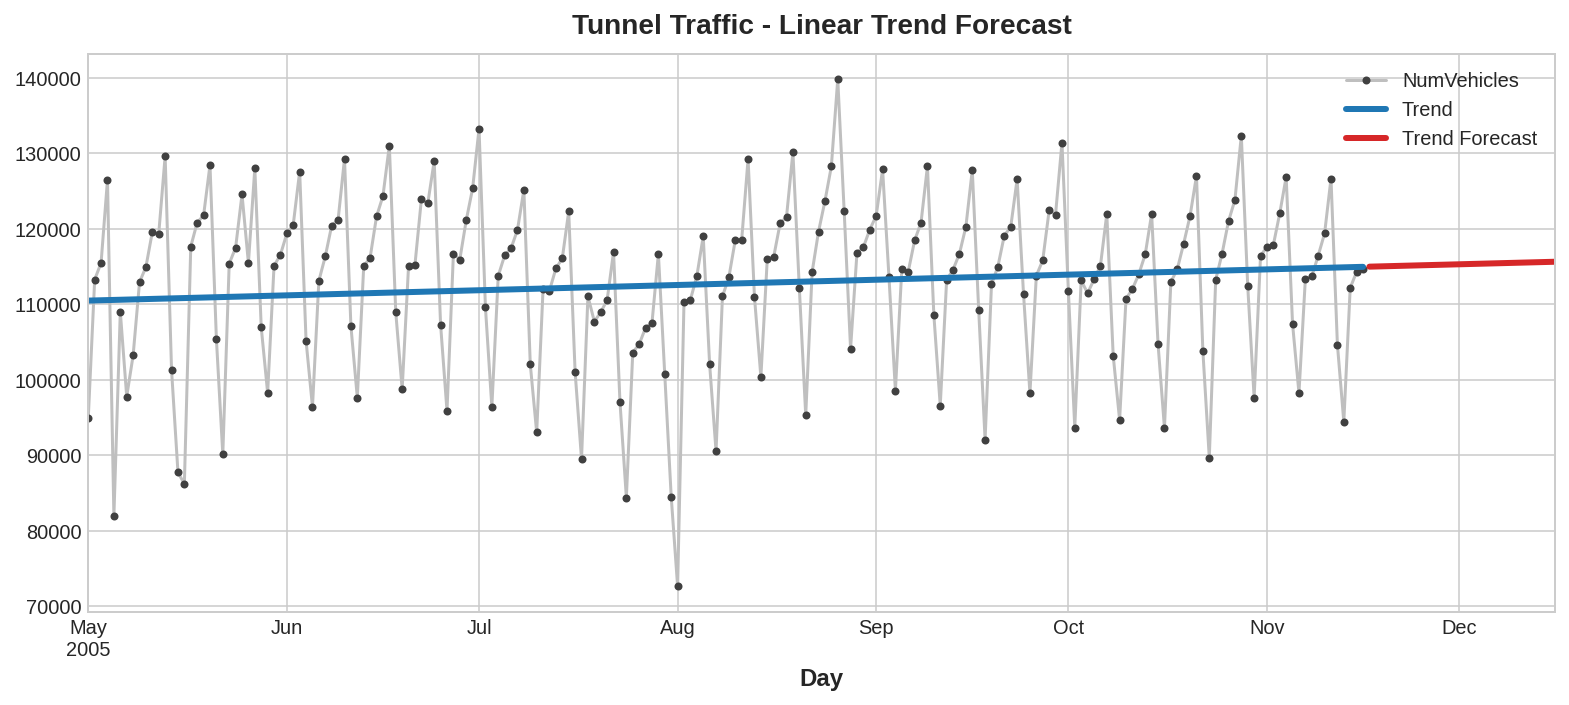

In [10]:

ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

---

The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique in Lesson 5.

# Your Turn #

[**Model trend in Store Sales**](https://www.kaggle.com/kernels/fork/19616015) and understand the risks of forecasting with high-order polynomials.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*